<a href="https://colab.research.google.com/github/NethmiJayasinghe/Cerebellum/blob/main/MNIST_SurpriseDetection_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/cerebellum

/content/gdrive/.shortcut-targets-by-id/1-1PwAYXnzX5UnHqeV31_ck5gfeNffQDu/cerebellum


In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt

directory = '/content/gdrive/MyDrive/cerebellum/MNIST_epoch1_eineuron1000_train1to9/'

In [ ]:
def spike_set(number_of_normal_images, number_of_anomaly_images):  # combining spike trains from multiple examples
  max_time_per_image = 4
  max_test_image_index = 15
  num_of_ei_neurons = 1000

  normal_images = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9]).astype(int)
  anomaly_images = np.array([0]).astype(int)
  # anomaly_images = np.array([1]).astype(int)

  spike_test_seq = []
  i = 0
  normal_index_list = []
  while i < number_of_normal_images:
    normal_instance = random.randint(0,max_test_image_index)
    normal_index_list.append(normal_instance)
    file_name = directory + 'spike_dict_label_' + str(random.choice(normal_images)) + '_instance_' + str(normal_instance) + '.txt'
    spike_test_seq.append(file_name)
    i += 1

  i = 0
  anomaly_index_list = []
  while i < number_of_anomaly_images:
    anomaly_instance = random.randint(0,max_test_image_index)
    anomaly_index_list.append(anomaly_instance)
    file_name = directory + 'spike_dict_label_' + str(random.choice(anomaly_images)) + '_instance_' + str(anomaly_instance) + '.txt'
    spike_test_seq.append(file_name)
    i += 1
  return spike_test_seq, normal_index_list, anomaly_index_list

In [ ]:
def spike_seq(spike_test_seq, number_of_normal_images, number_of_anomaly_images ,a,b, L):
  max_time_per_image = 4
  num_of_ei_neurons = 1000
  start_time = 0
  combined_sdict = {}

  for neurons in range(num_of_ei_neurons): combined_sdict[neurons] = np.array([])
  delW_STP, delW_LTP = 7, 7.5

  for s in spike_test_seq:
    # Read spike dictionary
    with open(s, 'r') as file:
      content = file.read()
      content = content.replace("array","np.array").replace(' * ksecond','').replace(' * second','').replace(', dtype=float64','')
      sdict = eval(content)
      for n in range(num_of_ei_neurons): sdict[n] = 1000*sdict[n]

    ei_count = 0   # Resetting spike times to start from zero
    all_spike_times = np.concatenate(list(sdict.values()))
    spike_onset = np.min(all_spike_times)
    spike_finish = np.max(all_spike_times)
    for neurons, spikes in sdict.items():
      if ei_count<= num_of_ei_neurons:
        reset_spikes =  (spikes - spike_onset)
        mask = reset_spikes <= max_time_per_image
        filtered_spikes = start_time + reset_spikes[mask]
        combined_sdict[neurons] = np.concatenate((combined_sdict[neurons], filtered_spikes))
      ei_count += 1
    start_time += max_time_per_image

  # Calculate potential profiles (all synapses)

  no_of_time_steps = 100 # time steps per image sample
  incr_time_steps = max_time_per_image/no_of_time_steps

  exc_cond = np.zeros((num_of_ei_neurons, no_of_time_steps*(number_of_normal_images+number_of_anomaly_images)))
  inh_cond = np.zeros((num_of_ei_neurons, no_of_time_steps*(number_of_normal_images+number_of_anomaly_images)))

  for t in range(no_of_time_steps*(number_of_normal_images+number_of_anomaly_images)):
    tr = t*incr_time_steps  # real time
    for i in range(num_of_ei_neurons):
        spike_times = combined_sdict[i]
        for j in range(len(spike_times)):
          exc_cond[i, t] += ((tr > spike_times[j])*delW_STP*(0.01*7.08*np.exp(-L*(tr - spike_times[j])* 2.92)+ 1.24e-10))
          inh_cond[i, t] += ((tr > spike_times[j])*delW_LTP*(10* 0.0018*np.exp(-L*(tr - spike_times[j])*0.79)+2.02e-08))

    del_S = 0.17226144*delW_STP**2 -3.88601669* delW_STP**1 + 21.89922614
    delW_STP += np.round(del_S, 2)*a
    del_L = -0.11476378* delW_LTP**1 + 1.21952141
    delW_LTP += np.round(del_L, 2)*b

  exc_cond_file_name = directory + 'exc_cond_normal_1to9_anomaly_0_updated.npy'
  inh_cond_file_name = directory + 'inh_cond_normal_1to9_anomaly_0_updated.npy'
  np.save(exc_cond_file_name, exc_cond)
  np.save(inh_cond_file_name, inh_cond)
  return num_of_ei_neurons

In [ ]:
spike_set_seq, normal_index_list, anomaly_index_list = spike_set(5,5)

In [ ]:
num_ei = spike_seq(spike_set_seq, 5,5, 7, 7.5, 0.2)

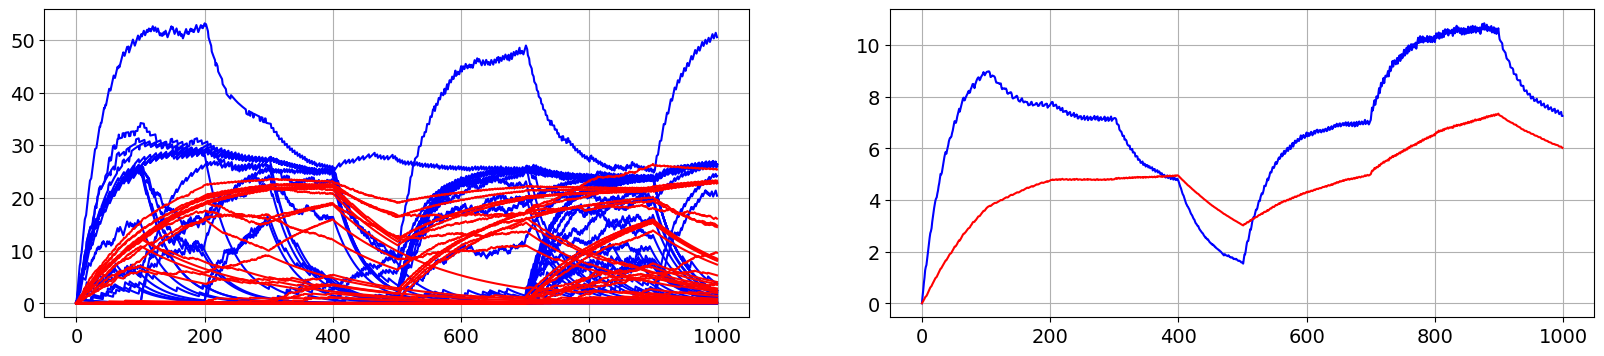

In [ ]:
# plot and debug
exc_cond_file_name = directory + 'exc_cond_normal_1to9_anomaly_0_updated.npy'
inh_cond_file_name = directory + 'inh_cond_normal_1to9_anomaly_0_updated.npy'
no_of_time_steps = 100
num_of_ei_neurons = 1000
number_of_normal_images, number_of_anomaly_images = 5,5
fig, axs = plt.subplots(1, 2 ,figsize=(20, 4))

no_of_e_synapse, no_of_i_synapse = 50, 50
exc_cond, inh_cond = np.load(exc_cond_file_name), np.load(inh_cond_file_name)
random_synapse_idx = np.random.permutation(np.arange(num_of_ei_neurons))
e_synapse_idx, i_synapse_idx = random_synapse_idx[0:no_of_e_synapse], random_synapse_idx[no_of_e_synapse:no_of_e_synapse+no_of_i_synapse]
t = np.arange(no_of_time_steps*(number_of_normal_images+number_of_anomaly_images)).reshape(-1,1)
for i in range(no_of_e_synapse):
  axs[0].plot(t,exc_cond[e_synapse_idx[i],:],'b')
for i in range(no_of_i_synapse):
  axs[0].plot(t,inh_cond[i_synapse_idx[i],:],'r')

axs[1].plot(t,np.mean(exc_cond[e_synapse_idx[0:no_of_e_synapse],:],axis=0),'b')
axs[1].plot(t,np.mean(inh_cond[i_synapse_idx[0:no_of_i_synapse],:],axis=0),'r')

for ax in axs:
    ax.grid(True)